In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

In [2]:
# 1. Load dataset
# wdbc.data does not have headers, so we define them
columns = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
data = pd.read_csv("wdbc.data", header=None, names=columns)

In [3]:
# 2. Prepare features and target
X = data.drop(["ID", "Diagnosis"], axis=1)
y = data["Diagnosis"].map({"M": 1, "B": 0})  # Malignant=1, Benign=0

In [4]:

# 4. Preprocessor (scaling not needed for trees, but kept for pipeline consistency)
num_features = X.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[("scale", StandardScaler(), num_features)],
    remainder="drop"
)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
# 5. Pipeline
pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])


In [7]:
# 6. Hyperparameter grid
param_grid = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [3, 5, 10],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
}

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True)
grid.fit(X_train, y_train)

print("Best Hyperparameters:", grid.best_params_)
print("Best Mean CV AUC:", grid.best_score_)

Best Hyperparameters: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10}
Best Mean CV AUC: 0.9558823529411764


In [9]:
# 8. Evaluate on test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

In [10]:

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))


Test Accuracy: 0.8771929824561403
Test Precision: 0.9117647058823529
Test Recall: 0.7380952380952381
Test F1: 0.8157894736842105
Test ROC AUC: 0.9654431216931217


/tmp/ipykernel_37889/1817741554.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


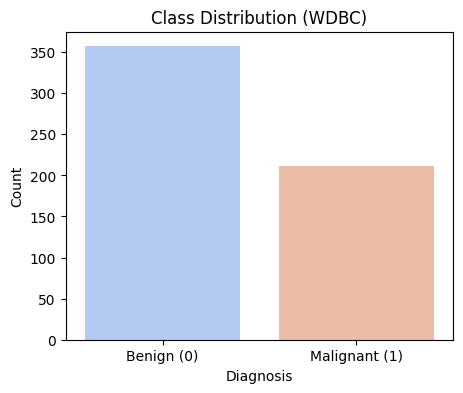

/tmp/ipykernel_37889/1817741554.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette="viridis")


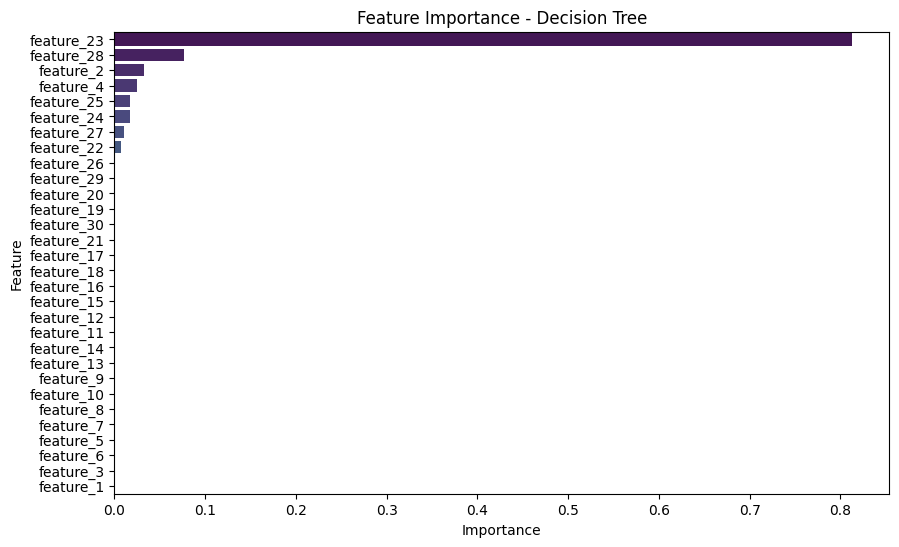

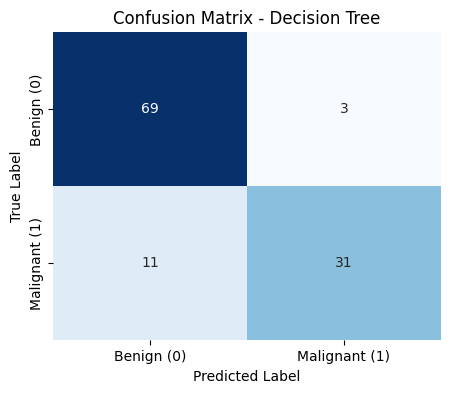

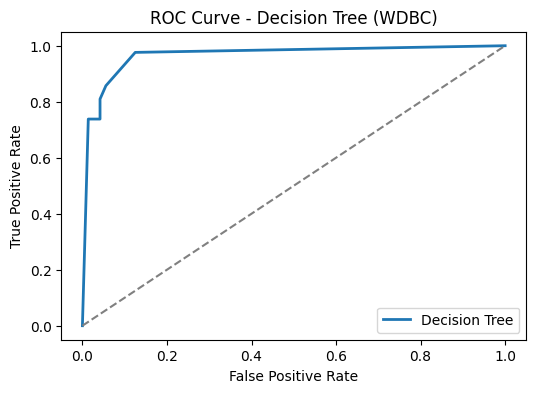

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ---- Class distribution ----
plt.figure(figsize=(5,4))
sns.countplot(x=y, palette="coolwarm")
plt.xticks([0,1], ["Benign (0)", "Malignant (1)"])
plt.title("Class Distribution (WDBC)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

# ---- Feature importance (from Decision Tree) ----
best_clf = best_model.named_steps["clf"]
importances = best_clf.feature_importances_
features = X.columns

# Sort feature importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices], palette="viridis")
plt.title("Feature Importance - Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Benign (0)", "Malignant (1)"],
            yticklabels=["Benign (0)", "Malignant (1)"])
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ---- ROC Curve (already included) ----
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Decision Tree", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree (WDBC)")
plt.legend()
plt.show()

In [12]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring={"accuracy": "accuracy", "f1": "f1_macro", "roc_auc": "roc_auc"},
    refit="roc_auc",  # still refit using AUC
    n_jobs=-1
)
grid.fit(X_train, y_train)


dt_results = pd.DataFrame(grid.cv_results_)

dt_table = dt_results[[
    "param_clf__criterion",
    "param_clf__max_depth",
    "mean_test_accuracy",
    "mean_test_f1",
    "mean_test_roc_auc"
]]

dt_table = dt_table.rename(columns={
    "param_clf__criterion": "criterion",
    "param_clf__max_depth": "max_depth",
    "mean_test_accuracy": "Accuracy",
    "mean_test_f1": "F1_score",
    "mean_test_roc_auc": "ROC_AUC"
})

# Pick random 10 with good accuracy
good_samples = dt_table[dt_table["Accuracy"] >= 0.8]
random_samples = good_samples.sample(n=10, random_state=42)

print(random_samples[["criterion", "max_depth", "Accuracy", "F1_score"]])


   criterion  max_depth  Accuracy  F1_score
30   entropy          3  0.925275  0.918155
0       gini          3  0.920879  0.913517
22      gini         10  0.929670  0.924123
31   entropy          3  0.925275  0.918155
18      gini         10  0.923077  0.917531
28   entropy          3  0.925275  0.918155
10      gini          5  0.912088  0.904949
70  log_loss          5  0.925275  0.919360
4       gini          3  0.920879  0.913042
12      gini          5  0.920879  0.913721


In [14]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Best Decision Tree with tuned hyperparameters
best_dt = DecisionTreeClassifier(
    criterion=grid.best_params_['clf__criterion'],
    max_depth=grid.best_params_['clf__max_depth'],
    min_samples_split=grid.best_params_['clf__min_samples_split'],
    min_samples_leaf=grid.best_params_['clf__min_samples_leaf'],
    random_state=42
)

# Pipeline with preprocessing
pipe_cv = Pipeline([
    ("prep", preprocessor),
    ("clf", best_dt)
])

# 5-Fold Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = cross_val_score(pipe_cv, X, y, cv=cv, scoring="accuracy")

# Print each fold's accuracy
for i, acc in enumerate(cv_accuracy, 1):
    print(f"Fold {i} Accuracy: {acc:.4f}")

# Print average accuracy
print(f"Average 5-Fold CV Accuracy: {cv_accuracy.mean():.4f}")

Fold 1 Accuracy: 0.9123
Fold 2 Accuracy: 0.8947
Fold 3 Accuracy: 0.9386
Fold 4 Accuracy: 0.9298
Fold 5 Accuracy: 0.9381
Average 5-Fold CV Accuracy: 0.9227
